In [1]:
#!pip install dateparser

# ----------------------------------------------
# 1. Cargar librerías
# ----------------------------------------------

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import openai
import time

In [8]:
from openai import OpenAI
import os

# Inicializar cliente con tu API Key (usando variable de entorno)
client = OpenAI(api_key=os.environ["OPENAI_API_KEY"])

🧪 Verificación rápida

In [9]:
import os
print("OPENAI_API_KEY" in os.environ)

True


# ----------------------------------------------
# 2. Cargar tu archivo original
# ----------------------------------------------

In [2]:
# Asegúrate que tu archivo esté en el mismo directorio
df = pd.read_csv("sentiment_data.csv")  # Debe contener una columna 'text' y 'date'

# Inicializar columnas para los resultados
df["fiscal_risk_score"] = None        # Puntaje del 1 al 5
df["risk_index"] = None               # Normalizado a escala 0.0–1.0

In [3]:
# Asegurar columnas necesarias
assert 'text' in df.columns, "Falta columna 'text' con los párrafos"
assert 'date' in df.columns, "Falta columna 'date' con la fecha del documento"

In [4]:
df.head(20)

,filename,year,date,announcement,page,paragraph_id,text,fiscal_risk_score,risk_index
0,Comunicado-012024-RiesgosFiscales-v4-1.pdf,2024.0,1 de febrero de 2024,NaN,1,3,El CF considera que incumplir la regla fiscal ...,None,None
1,Comunicado-012024-RiesgosFiscales-v4-1.pdf,2024.0,1 de febrero de 2024,NaN,1,4,"No obstante, el CF observa que las últimas med...",None,None
2,Comunicado-012024-RiesgosFiscales-v4-1.pdf,2024.0,1 de febrero de 2024,NaN,1,5,"En el caso de las medidas tributarias, el CF o...",None,None
3,Comunicado-012024-RiesgosFiscales-v4-1.pdf,2024.0,1 de febrero de 2024,NaN,2,9,Un ejemplo de las presiones antes mencionadas ...,None,None
4,Comunicado-012024-RiesgosFiscales-v4-1.pdf,2024.0,1 de febrero de 2024,NaN,3,12,"Adicionalmente, el CF considera que actualment...",None,None
5,Comunicado-012024-RiesgosFiscales-v4-1.pdf,2024.0,1 de febrero de 2024,NaN,3,13,Cabe resaltar que el marco legal que autoriza ...,None,None
6,Comunicado-012024-RiesgosFiscales-v4-1.pdf,2024.0,1 de febrero de 2024,NaN,4,15,"Adicionalmente, en cuanto a la situación de Pe...",None,None
7,Comunicado-012024-RiesgosFiscales-v4-1.pdf,2024.0,1 de febrero de 2024,NaN,1,2,El CF observa que en 2023 se habría registrado...,None,None
8,Comunicado-012024-RiesgosFiscales-v4-1.pdf,2024.0,1 de febrero de 2024,NaN,4,16,"Finalmente, el CF recuerda que la sostenibilid...",None,None
9,Comunicado-012024-RiesgosFiscales-v4-1.pdf,2024.0,1 de febrero de 2024,NaN,1,1,"El Consejo Fiscal, con el objeto de contribuir...",None,None


In [5]:
import pandas as pd
import dateparser

def parse_spanish_dates(df, column_name):
    """
    Convierte una columna de fechas en español a datetime.
    
    Parámetros:
        df (pd.DataFrame): El DataFrame con la columna a procesar.
        column_name (str): El nombre de la columna con fechas en español.

    Retorna:
        pd.DataFrame: El DataFrame original con la columna convertida a datetime.
    """
    df[column_name] = df[column_name].apply(
        lambda x: dateparser.parse(x, languages=['es']) if pd.notnull(x) else None
    )
    return df


In [6]:
# Aplica la función
df = parse_spanish_dates(df, 'date')

# Verifica
print(df[['date']].head(5))

        date
0 2024-02-01
1 2024-02-01
2 2024-02-01
3 2024-02-01
4 2024-02-01


In [7]:
df

,filename,year,date,announcement,page,paragraph_id,text,fiscal_risk_score,risk_index
0,Comunicado-012024-RiesgosFiscales-v4-1.pdf,2024.0,2024-02-01,NaN,1,3,El CF considera que incumplir la regla fiscal ...,None,None
1,Comunicado-012024-RiesgosFiscales-v4-1.pdf,2024.0,2024-02-01,NaN,1,4,"No obstante, el CF observa que las últimas med...",None,None
2,Comunicado-012024-RiesgosFiscales-v4-1.pdf,2024.0,2024-02-01,NaN,1,5,"En el caso de las medidas tributarias, el CF o...",None,None
3,Comunicado-012024-RiesgosFiscales-v4-1.pdf,2024.0,2024-02-01,NaN,2,9,Un ejemplo de las presiones antes mencionadas ...,None,None
4,Comunicado-012024-RiesgosFiscales-v4-1.pdf,2024.0,2024-02-01,NaN,3,12,"Adicionalmente, el CF considera que actualment...",None,None
...,...,...,...,...,...,...,...,...,...
372,Informe-DCRF2023-vf.pdf,NaN,NaT,NaN,6,37,Si bien existe incertidumbre sobre los precios...,None,None
373,Informe-DCRF2023-vf.pdf,NaN,NaT,NaN,7,40,"Para el 2024, las perspectivas actuales sugier...",None,None
374,Informe-DCRF2023-vf.pdf,NaN,NaT,NaN,7,42,Extender del 2026 al 2028 la consolidación del...,None,None
375,Informe-DCRF2023-vf.pdf,NaN,NaT,NaN,7,43,"Debido a lo señalado previamente, el CF consid...",None,None


# ----------------------------------------------
# 3. Función para obtener score desde GPT (1–5)
# ----------------------------------------------

In [12]:
context = """
Sabemos que desde aproximadamente 2016 el manejo de las finanzas públicas ha mostrado signos crecientes de deterioro. 
La pérdida de disciplina fiscal, la falta de transparencia y el relajamiento de las reglas fiscales han sido temas 
recurrentes en los informes del Consejo. A ello se suma el impacto de la inestabilidad política —con frecuentes cambios 
ministeriales— sobre la capacidad institucional para llevar una política fiscal prudente y sostenible. En este contexto, 
el Consejo ha venido alertando con más frecuencia y firmeza sobre el incumplimiento de metas fiscales, el deterioro del 
balance público, y los riesgos de un endeudamiento creciente y potencialmente insostenible.

Criterios comunes en los informes del Consejo Fiscal (según categoría):

1. Cumplimiento y disciplina fiscal:
(disciplina fiscal, incumplimiento de metas fiscales, relajamiento de reglas fiscales, uso inadecuado del gasto público, desviación del déficit fiscal, deterioro del marco fiscal, flexibilización sin justificación, política fiscal procíclica)

2. Riesgo y sostenibilidad:
(riesgo fiscal, riesgo de sostenibilidad de la deuda, endeudamiento excesivo, dependencia de ingresos extraordinarios, vulnerabilidad fiscal estructural, uso de medidas transitorias o no permanentes, incertidumbre macrofiscal)

3. Gobernanza e institucionalidad:
(transparencia fiscal, calidad del gasto público, incertidumbre institucional, falta de planificación multianual, cambios frecuentes en autoridades económicas, debilitamiento institucional, independencia fiscal comprometida, ausencia de reforma estructural)
"""

    """
    Evalúa un párrafo de un informe fiscal utilizando GPT-4o y asigna un score del 1 al 5
    según el nivel de preocupación o alarma fiscal expresado.

    Returns:
        - int (1 a 5): Score de riesgo fiscal asignado por el modelo
        - None: En caso de error o respuesta inválida
    """

Interpretación:
- 1 = Sin preocupación fiscal (consolidación fiscal sostenida, cumplimiento de metas, transparencia fiscal, calidad del gasto público, planificación multianual)
- 2 = Ligera preocupación (observaciones menores, advertencias marginales, riesgo fiscal potencial, uso de medidas transitorias o ingresos extraordinarios)
- 3 = Neutral (descripción técnica sin énfasis positivo ni negativo, gestión fiscal dentro del marco previsto)
- 4 = Alta preocupación (incumplimiento de metas, flexibilización sin justificación, incertidumbre macrofiscal, debilitamiento institucional)
- 5 = Alarma fiscal (críticas severas, endeudamiento excesivo, deterioro del marco fiscal, independencia fiscal comprometida)

In [13]:
def get_llm_score(text):
    prompt = f"""
Eres un analista técnico del Consejo Fiscal de Perú. Evalúa el siguiente párrafo extraído de un informe técnico del Consejo Fiscal (CF), donde se emite una opinión sobre el desempeño fiscal del Ministerio de Economía y Finanzas (MEF) en cuanto al cumplimiento de las metas fiscales.

Tu tarea es asignar un **puntaje del 1 al 5** según el **nivel de preocupación o alerta fiscal expresado en el texto**.

Interpretación:
- 1 = Sin preocupación fiscal (cumplimiento de metas, transparencia fiscal, planificación multianual)
- 2 = Ligera preocupación (riesgo fiscal potencial, desviación del déficit, dependencia de ingresos extraordinarios)
- 3 = Neutral (descripción técnica, gestión dentro del marco, sin juicio valorativo)
- 4 = Alta preocupación (incumplimiento de metas, relajamiento fiscal, incertidumbre macroeconómica)
- 5 = Alarma fiscal (críticas severas, riesgo de sostenibilidad de la deuda, independencia fiscal comprometida)

Devuelve solo un número del 1 al 5.

Texto:
\"\"\"{text}\"\"\"
""".strip()

    try:
        response = client.chat.completions.create(
            model="gpt-4o",
            messages=[{"role": "user", "content": prompt}],
            temperature=0,
            max_tokens=5,
        )
        result = response.choices[0].message.content.strip()
        if result in {'1', '2', '3', '4', '5'}:
            return int(result)
        else:
            print(f"⚠️ Respuesta inesperada: {result}")
            return None
    except Exception as e:
        print(f"❌ Error: {e}")
        return None


# ----------------------------------------------
# 4. Ejecutar clasificación (con backup y control de crédito)
# ----------------------------------------------

In [14]:
import openai
print(openai.__version__)


1.91.0


In [15]:
from datetime import datetime

start = time.time()

for i, row in df.iterrows():
    if pd.notna(row["fiscal_risk_score"]):
        continue  # Ya procesado

    score = get_llm_score(row["text"])

    # Guardar score
    df.at[i, "fiscal_risk_score"] = score
    df.at[i, "risk_index"] = score / 5 if score else None

    # Backup cada 10 filas
    if i % 10 == 0:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        df.to_csv(f"backup_fiscal_risk_{timestamp}.csv", index=False)
        print(f"💾 Backup guardado en fila {i} - {timestamp}")

    time.sleep(1.2)  # Control para no sobrecargar

end = time.time()
print(f"✅ Proceso completado en {round((end - start)/60, 2)} minutos.")



💾 Backup guardado en fila 0 - 20250711_105500
💾 Backup guardado en fila 10 - 20250711_105519
💾 Backup guardado en fila 20 - 20250711_105538
💾 Backup guardado en fila 30 - 20250711_105555
💾 Backup guardado en fila 40 - 20250711_105612
💾 Backup guardado en fila 50 - 20250711_105631
💾 Backup guardado en fila 60 - 20250711_105648
💾 Backup guardado en fila 70 - 20250711_105707
💾 Backup guardado en fila 80 - 20250711_105727
💾 Backup guardado en fila 90 - 20250711_105744
💾 Backup guardado en fila 100 - 20250711_105801
💾 Backup guardado en fila 110 - 20250711_105817
💾 Backup guardado en fila 120 - 20250711_105834
💾 Backup guardado en fila 130 - 20250711_105854
💾 Backup guardado en fila 140 - 20250711_105913
💾 Backup guardado en fila 150 - 20250711_105929
💾 Backup guardado en fila 160 - 20250711_105947
💾 Backup guardado en fila 170 - 20250711_110004
💾 Backup guardado en fila 180 - 20250711_110022
💾 Backup guardado en fila 190 - 20250711_110040
💾 Backup guardado en fila 200 - 20250711_110058
💾 B

# Guardar resultados completos

In [16]:
df.to_csv("df_fiscal_scored.csv", index=False)

In [19]:
df.head(5)

,filename,year,date,announcement,page,paragraph_id,text,fiscal_risk_score,risk_index
0,Comunicado-012024-RiesgosFiscales-v4-1.pdf,2024.0,2024-02-01,NaN,1,3,El CF considera que incumplir la regla fiscal ...,4,0.8
1,Comunicado-012024-RiesgosFiscales-v4-1.pdf,2024.0,2024-02-01,NaN,1,4,"No obstante, el CF observa que las últimas med...",4,0.8
2,Comunicado-012024-RiesgosFiscales-v4-1.pdf,2024.0,2024-02-01,NaN,1,5,"En el caso de las medidas tributarias, el CF o...",4,0.8
3,Comunicado-012024-RiesgosFiscales-v4-1.pdf,2024.0,2024-02-01,NaN,2,9,Un ejemplo de las presiones antes mencionadas ...,4,0.8
4,Comunicado-012024-RiesgosFiscales-v4-1.pdf,2024.0,2024-02-01,NaN,3,12,"Adicionalmente, el CF considera que actualment...",5,1.0


# Fleeting inspect

In [17]:
df["fiscal_risk_score"].value_counts(dropna=False).sort_index()

fiscal_risk_score
1     19
2     77
3     44
4    216
5     21
Name: count, dtype: int64

In [18]:
df["risk_index"].describe()

count     377.0
unique      5.0
top         0.8
freq      216.0
Name: risk_index, dtype: float64

# ----------------------------------------------
# 5. Agregar score promedio por fecha
# ----------------------------------------------

# Aggregation

In [20]:
df_doc_avg = df.groupby(['filename', 'date']).agg(
    avg_risk_score=('fiscal_risk_score', 'mean'),
    avg_risk_index=('risk_index', 'mean'),
    n_paragraphs=('fiscal_risk_score', 'count')
).reset_index()

In [21]:
df_doc_avg

,filename,date,avg_risk_score,avg_risk_index,n_paragraphs
0,CF-Informe-IAPM21-vF.pdf,2021-05-19,3.375,0.675,8
1,CF-Informe-MMM2124-cNotaAclaratoria-28-de-agos...,2020-08-14,3.789474,0.757895,19
2,CF-Informe-MMM2124-publicado-enviado-CF-VF.pdf,2020-09-16,4.142857,0.828571,7
3,CF-Pronunciamiento-MMM-2019-2022_15_8_2018-env...,2018-08-15,2.916667,0.583333,12
4,CF-Pronunciamiento-MMM-2020-2023-Versión-Final...,2019-08-15,2.166667,0.433333,6
5,CF-Pronunciamiento.pdf,2018-05-24,3.166667,0.633333,6
6,Comunicado-01-2025-ReglasFiscales-vf-1.pdf,2025-01-20,3.75,0.75,12
7,Comunicado-012024-RiesgosFiscales-v4-1.pdf,2024-02-01,3.8,0.76,10
8,Comunicado-03-IAPM-vf.pdf,2025-05-05,4.0,0.8,4
9,Comunicado-CF-161220.pdf,2020-12-16,4.0,0.8,2


In [22]:
df_score_dist = (
    df.pivot_table(index=['filename', 'date'], 
                   columns='fiscal_risk_score', 
                   values='text', 
                   aggfunc='count', 
                   fill_value=0)
    .reset_index()
    .rename(columns={1: 'score_1', 2: 'score_2', 3: 'score_3', 4: 'score_4', 5: 'score_5'})
)


In [23]:
df_score_dist

fiscal_risk_score,filename,date,score_1,score_2,score_3,score_4,score_5
0,CF-Informe-IAPM21-vF.pdf,2021-05-19,1,1,0,6,0
1,CF-Informe-MMM2124-cNotaAclaratoria-28-de-agos...,2020-08-14,1,1,3,10,4
2,CF-Informe-MMM2124-publicado-enviado-CF-VF.pdf,2020-09-16,0,0,0,6,1
3,CF-Pronunciamiento-MMM-2019-2022_15_8_2018-env...,2018-08-15,2,3,1,6,0
4,CF-Pronunciamiento-MMM-2020-2023-Versión-Final...,2019-08-15,3,1,0,2,0
5,CF-Pronunciamiento.pdf,2018-05-24,0,2,2,1,1
6,Comunicado-01-2025-ReglasFiscales-vf-1.pdf,2025-01-20,0,0,3,9,0
7,Comunicado-012024-RiesgosFiscales-v4-1.pdf,2024-02-01,0,1,1,7,1
8,Comunicado-03-IAPM-vf.pdf,2025-05-05,0,0,0,4,0
9,Comunicado-CF-161220.pdf,2020-12-16,0,0,0,2,0


In [24]:
score_cols = ['score_1', 'score_2', 'score_3', 'score_4', 'score_5']
df_score_dist[score_cols] = df_score_dist[score_cols].div(df_score_dist[score_cols].sum(axis=1), axis=0)


In [25]:
df_score_dist

fiscal_risk_score,filename,date,score_1,score_2,score_3,score_4,score_5
0,CF-Informe-IAPM21-vF.pdf,2021-05-19,0.125000,0.125000,0.000000,0.750000,0.000000
1,CF-Informe-MMM2124-cNotaAclaratoria-28-de-agos...,2020-08-14,0.052632,0.052632,0.157895,0.526316,0.210526
2,CF-Informe-MMM2124-publicado-enviado-CF-VF.pdf,2020-09-16,0.000000,0.000000,0.000000,0.857143,0.142857
3,CF-Pronunciamiento-MMM-2019-2022_15_8_2018-env...,2018-08-15,0.166667,0.250000,0.083333,0.500000,0.000000
4,CF-Pronunciamiento-MMM-2020-2023-Versión-Final...,2019-08-15,0.500000,0.166667,0.000000,0.333333,0.000000
5,CF-Pronunciamiento.pdf,2018-05-24,0.000000,0.333333,0.333333,0.166667,0.166667
6,Comunicado-01-2025-ReglasFiscales-vf-1.pdf,2025-01-20,0.000000,0.000000,0.250000,0.750000,0.000000
7,Comunicado-012024-RiesgosFiscales-v4-1.pdf,2024-02-01,0.000000,0.100000,0.100000,0.700000,0.100000
8,Comunicado-03-IAPM-vf.pdf,2025-05-05,0.000000,0.000000,0.000000,1.000000,0.000000
9,Comunicado-CF-161220.pdf,2020-12-16,0.000000,0.000000,0.000000,1.000000,0.000000


In [26]:
df_doc_summary = pd.merge(df_doc_avg, df_score_dist, on=['filename', 'date'])


In [27]:
df_doc_summary

,filename,date,avg_risk_score,avg_risk_index,n_paragraphs,score_1,score_2,score_3,score_4,score_5
0,CF-Informe-IAPM21-vF.pdf,2021-05-19,3.375,0.675,8,0.125000,0.125000,0.000000,0.750000,0.000000
1,CF-Informe-MMM2124-cNotaAclaratoria-28-de-agos...,2020-08-14,3.789474,0.757895,19,0.052632,0.052632,0.157895,0.526316,0.210526
2,CF-Informe-MMM2124-publicado-enviado-CF-VF.pdf,2020-09-16,4.142857,0.828571,7,0.000000,0.000000,0.000000,0.857143,0.142857
3,CF-Pronunciamiento-MMM-2019-2022_15_8_2018-env...,2018-08-15,2.916667,0.583333,12,0.166667,0.250000,0.083333,0.500000,0.000000
4,CF-Pronunciamiento-MMM-2020-2023-Versión-Final...,2019-08-15,2.166667,0.433333,6,0.500000,0.166667,0.000000,0.333333,0.000000
5,CF-Pronunciamiento.pdf,2018-05-24,3.166667,0.633333,6,0.000000,0.333333,0.333333,0.166667,0.166667
6,Comunicado-01-2025-ReglasFiscales-vf-1.pdf,2025-01-20,3.75,0.75,12,0.000000,0.000000,0.250000,0.750000,0.000000
7,Comunicado-012024-RiesgosFiscales-v4-1.pdf,2024-02-01,3.8,0.76,10,0.000000,0.100000,0.100000,0.700000,0.100000
8,Comunicado-03-IAPM-vf.pdf,2025-05-05,4.0,0.8,4,0.000000,0.000000,0.000000,1.000000,0.000000
9,Comunicado-CF-161220.pdf,2020-12-16,4.0,0.8,2,0.000000,0.000000,0.000000,1.000000,0.000000


# ----------------------------------------------
# 6. Visualizar índice fiscal
# ----------------------------------------------

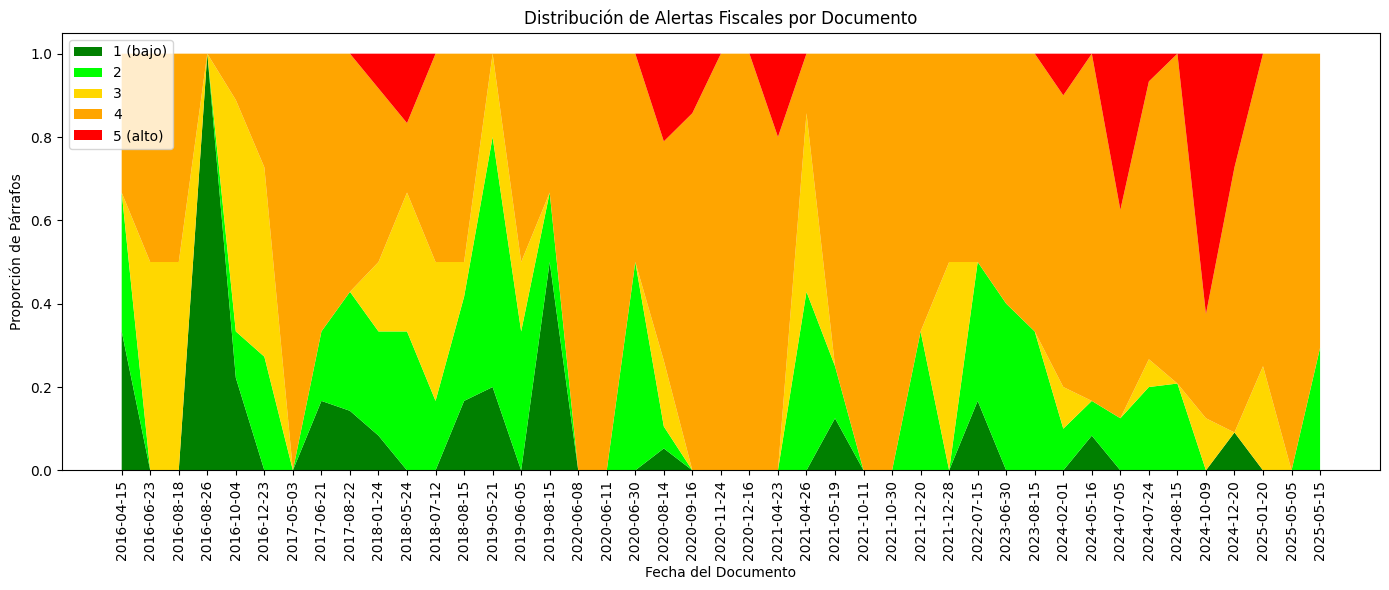

In [32]:
df_plot = df_doc_summary.sort_values('date')
df_plot['date_str'] = df_plot['date'].dt.strftime('%Y-%m-%d')

plt.figure(figsize=(14, 6))
plt.stackplot(df_plot['date_str'], 
              df_plot['score_1'], 
              df_plot['score_2'], 
              df_plot['score_3'], 
              df_plot['score_4'], 
              df_plot['score_5'], 
              labels=['1 (bajo)', '2', '3', '4', '5 (alto)'],
              colors=['green', 'lime', 'gold', 'orange', 'red'])
plt.legend(loc='upper left')
plt.title("Distribución de Alertas Fiscales por Documento")
plt.xlabel("Fecha del Documento")
plt.ylabel("Proporción de Párrafos")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


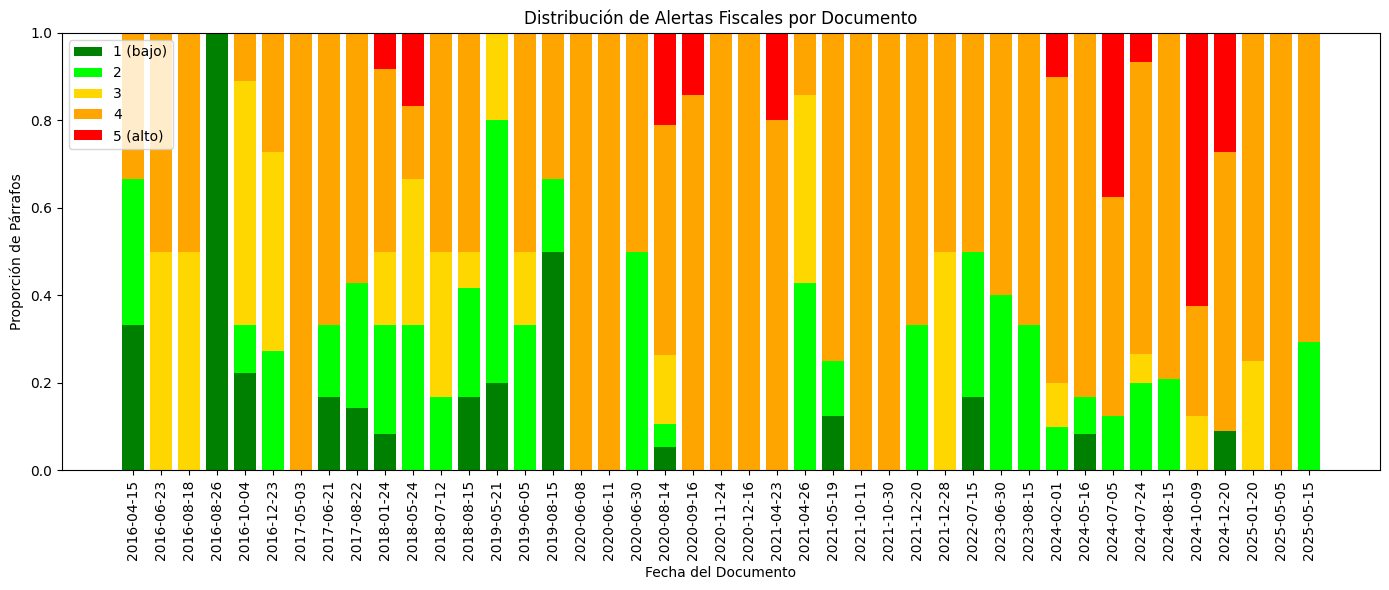

In [69]:
import matplotlib.pyplot as plt
import numpy as np

# Ordena y convierte fechas a string
df_plot = df_doc_summary.sort_values('date')
df_plot['date_str'] = df_plot['date'].dt.strftime('%Y-%m-%d')

# Datos para apilamiento
x = np.arange(len(df_plot))
scores = ['score_1', 'score_2', 'score_3', 'score_4', 'score_5']
colors = ['green', 'lime', 'gold', 'orange', 'red']
labels = ['1 (bajo)', '2', '3', '4', '5 (alto)']

# Inicializa el fondo de cada barra en 0
bottom = np.zeros(len(df_plot))

plt.figure(figsize=(14, 6))

# Graficar cada score como una capa apilada
for i, score in enumerate(scores):
    plt.bar(x, df_plot[score], bottom=bottom, label=labels[i], color=colors[i])
    bottom += df_plot[score].values

# Ajustes finales
plt.xticks(x, df_plot['date_str'], rotation=90)
plt.legend(loc='upper left')
plt.title("Distribución de Alertas Fiscales por Documento")
plt.xlabel("Fecha del Documento")
plt.ylabel("Proporción de Párrafos")
plt.tight_layout()
plt.show()


# CMA

In [34]:
df_doc_summary = df_doc_summary.sort_values("date")

In [35]:
# Calcula la media móvil centrada con ventana de 3 documentos
df_doc_summary["cma_risk_index"] = df_doc_summary["avg_risk_index"].rolling(window=3, center=True).mean()


$$
\text{CMA}_t = \frac{4X_{t-1} + 2X_t + X_{t+1}}{7}
$$

# Áreas apiladas

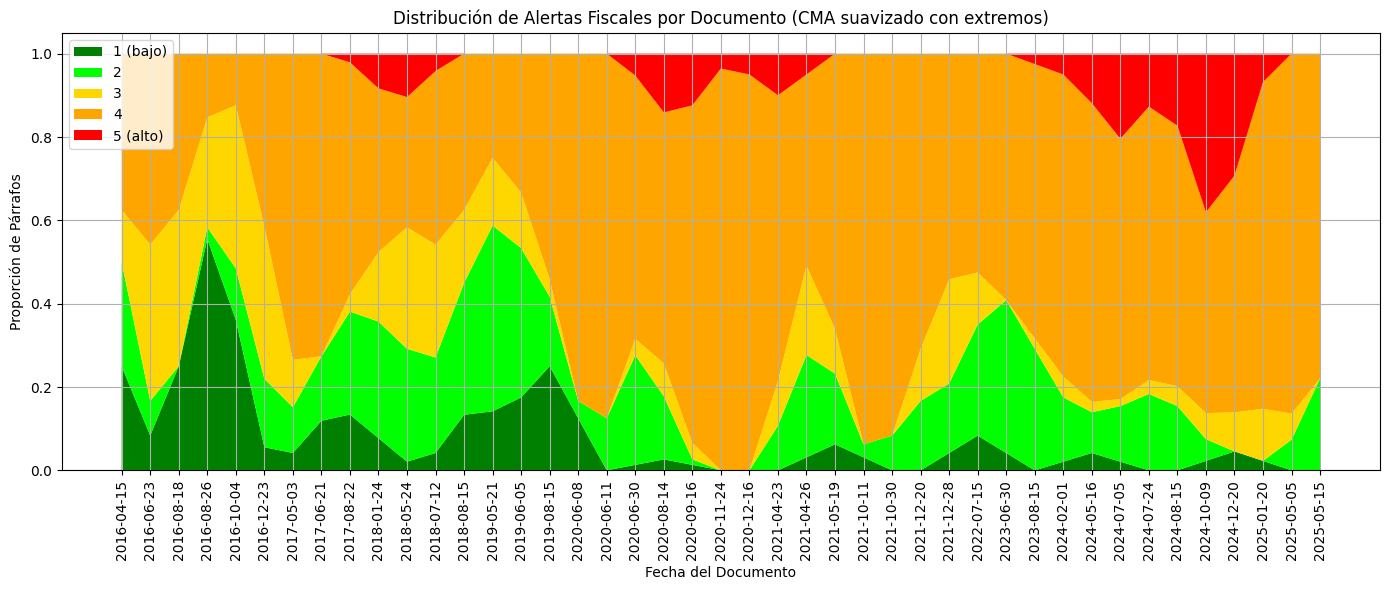

In [77]:
import numpy as np
import matplotlib.pyplot as plt

# Asegurar orden por fecha
df_doc_summary = df_doc_summary.sort_values("date").reset_index(drop=True)
df_doc_summary['date_str'] = df_doc_summary['date'].dt.strftime('%Y-%m-%d')

# Pesos del suavizamiento
weights = np.array([1, 2, 1])

# Aplicar CMA con bordes extendidos a cada score
for col in ['score_1', 'score_2', 'score_3', 'score_4', 'score_5']:
    series = df_doc_summary[col].copy()

    middle_cma = (
        series.rolling(window=3, center=True)
        .apply(lambda x: np.dot(x, weights) / 4, raw=True)
    )

    # Bordes
    first = series.iloc[0]
    second = series.iloc[1]
    first_smoothed = (3 * first + second) / 4

    last = series.iloc[-1]
    penultimate = series.iloc[-2]
    last_smoothed = (3 * last + penultimate) / 4

    # Insertar bordes
    middle_cma.iloc[0] = first_smoothed
    middle_cma.iloc[-1] = last_smoothed

    df_doc_summary[f'{col}_cma'] = middle_cma

# Configuración para el gráfico
cols_cma = ['score_1_cma', 'score_2_cma', 'score_3_cma', 'score_4_cma', 'score_5_cma']
labels = ['1 (bajo)', '2', '3', '4', '5 (alto)']
colors = ['green', 'lime', 'gold', 'orange', 'red']

# Gráfico de áreas apiladas suavizadas
plt.figure(figsize=(14, 6))
plt.stackplot(df_doc_summary['date_str'], 
              *[df_doc_summary[col] for col in cols_cma],
              labels=labels,
              colors=colors)

plt.title("Distribución de Alertas Fiscales por Documento (CMA suavizado con extremos)")
plt.xlabel("Fecha del Documento")
plt.ylabel("Proporción de Párrafos")
plt.xticks(rotation=90)
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()

# Guardar gráfico
plt.savefig("stacked_areas.png", dpi=300)
plt.show()



# Barras apiladas

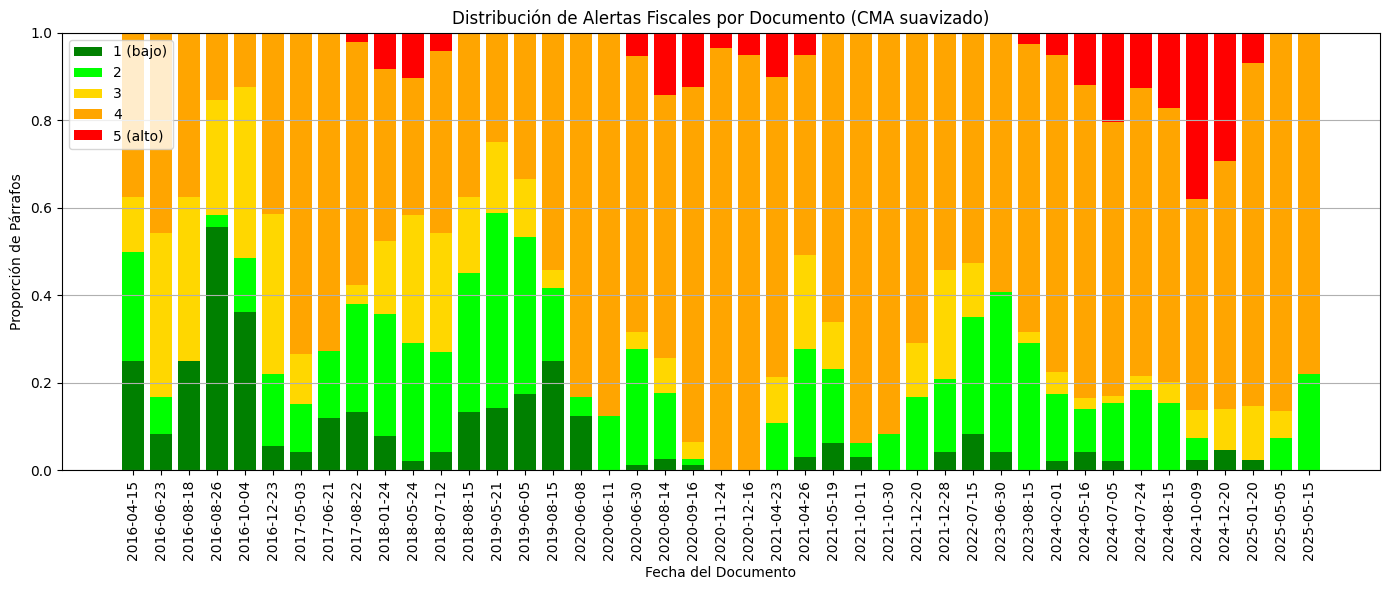

In [72]:
import numpy as np
import matplotlib.pyplot as plt

# Asegurar orden por fecha
df_doc_summary = df_doc_summary.sort_values("date").reset_index(drop=True)
df_doc_summary['date_str'] = df_doc_summary['date'].dt.strftime('%Y-%m-%d')

# Pesos del suavizamiento
weights = np.array([1, 2, 1])

# Aplicar CMA con bordes extendidos a cada score
for col in ['score_1', 'score_2', 'score_3', 'score_4', 'score_5']:
    series = df_doc_summary[col].copy()

    # Suavizado centrado
    middle_cma = (
        series.rolling(window=3, center=True)
        .apply(lambda x: np.dot(x, weights) / 4, raw=True)
    )

    # Bordes: primero y último
    first = series.iloc[0]
    second = series.iloc[1]
    first_smoothed = (3 * first + second) / 4

    last = series.iloc[-1]
    penultimate = series.iloc[-2]
    last_smoothed = (3 * last + penultimate) / 4

    # Insertar bordes
    middle_cma.iloc[0] = first_smoothed
    middle_cma.iloc[-1] = last_smoothed

    # Guardar en columna nueva
    df_doc_summary[f'{col}_cma'] = middle_cma

# Configuración para el gráfico
cols_cma = ['score_1_cma', 'score_2_cma', 'score_3_cma', 'score_4_cma', 'score_5_cma']
labels = ['1 (bajo)', '2', '3', '4', '5 (alto)']
colors = ['green', 'lime', 'gold', 'orange', 'red']

# Crear figura
plt.figure(figsize=(14, 6))

# Inicializar base inferior de las barras (todo comienza desde 0)
bottom = np.zeros(len(df_doc_summary))

# Crear barras apiladas
for col, label, color in zip(cols_cma, labels, colors):
    plt.bar(df_doc_summary['date_str'], df_doc_summary[col],
            bottom=bottom, label=label, color=color)
    bottom += df_doc_summary[col]  # actualizar base inferior para la siguiente capa

# Formato del gráfico
plt.legend(loc='upper left')
plt.title("Distribución de Alertas Fiscales por Documento (CMA suavizado)")
plt.xlabel("Fecha del Documento")
plt.ylabel("Proporción de Párrafos")
plt.xticks(rotation=90)
plt.tight_layout()
plt.grid(True, axis='y')
plt.show()


# 2 balance stats

In [49]:
df_doc_summary

,filename,date,avg_risk_score,avg_risk_index,n_paragraphs,score_1,score_2,score_3,score_4,score_5,date_str,cma_risk_index,cma_weighted,score_1_cma,score_2_cma,score_3_cma,score_4_cma,score_5_cma,balance_A,balance_B
0,Informe_CF_N_002-2016.pdf,2016-04-15,2.333333,0.466667,3,0.333333,0.333333,0.000000,0.333333,0.000000,2016-04-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.333333,0.000000
1,Informe_CF_N_003-2016.pdf,2016-06-23,3.5,0.7,4,0.000000,0.000000,0.500000,0.500000,0.000000,2016-06-23,0.622222,0.641667,0.083333,0.083333,0.375000,0.458333,0.000000,0.000000,0.500000
2,Informe_CF_N_004-2016.pdf,2016-08-18,3.5,0.7,2,0.000000,0.000000,0.500000,0.500000,0.000000,2016-08-18,0.533333,0.575000,0.250000,0.000000,0.375000,0.375000,0.000000,0.000000,0.500000
3,Informe_CF_N_006-2016.pdf,2016-08-26,1.0,0.2,1,1.000000,0.000000,0.000000,0.000000,0.000000,2016-08-26,0.470370,0.402778,0.555556,0.027778,0.263889,0.152778,0.000000,-1.000000,-1.000000
4,Informe_CF_N_007-2016.pdf,2016-10-04,2.555556,0.511111,9,0.222222,0.111111,0.555556,0.111111,0.000000,2016-10-04,0.437037,0.455556,0.361111,0.123737,0.391414,0.123737,0.000000,-0.222222,-0.111111
5,Informe_CF_N_008-2016-OPINION SOBRE EL NUEVO M...,2016-12-23,3.0,0.6,11,0.000000,0.272727,0.454545,0.272727,0.000000,2016-12-23,0.637037,0.627778,0.055556,0.164141,0.366162,0.414141,0.000000,0.000000,0.272727
6,INFORME_N_001-2017-CF.pdf,2017-05-03,4.0,0.8,1,0.000000,0.000000,0.000000,1.000000,0.000000,2017-05-03,0.677778,0.708333,0.041667,0.109848,0.113636,0.734848,0.000000,0.000000,1.000000
7,INFORME_N_003-2017-CF.pdf,2017-06-21,3.166667,0.633333,6,0.166667,0.166667,0.000000,0.666667,0.000000,2017-06-21,0.677778,0.666667,0.119048,0.154762,0.000000,0.726190,0.000000,-0.166667,0.500000
8,INFORME_N_004-2017-CF.pdf,2017-08-22,3.0,0.6,7,0.142857,0.285714,0.000000,0.571429,0.000000,2017-08-22,0.622222,0.616667,0.133929,0.247024,0.041667,0.556548,0.020833,-0.142857,0.428571
9,Informe-N°-001-2018-CF.pdf,2018-01-24,3.166667,0.633333,12,0.083333,0.250000,0.166667,0.416667,0.083333,2018-01-24,0.622222,0.625000,0.077381,0.279762,0.166667,0.392857,0.083333,0.000000,0.416667


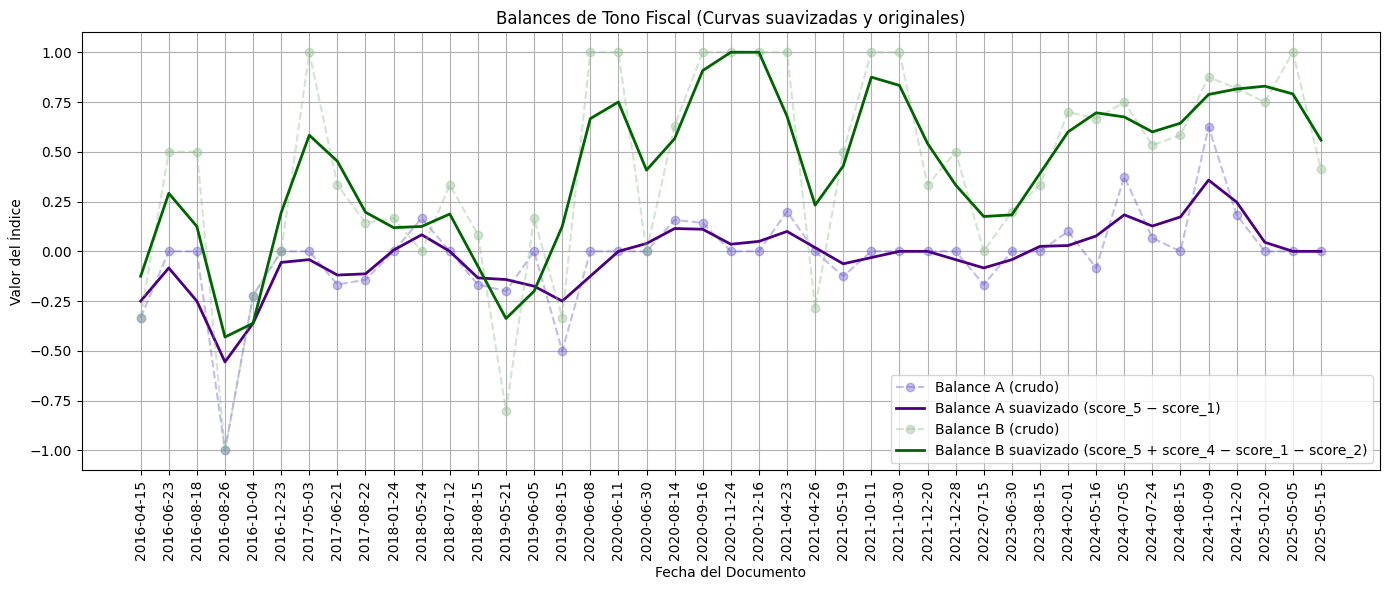

In [76]:
import matplotlib.pyplot as plt
import numpy as np

# Recalcular balances si aún no lo hiciste
df_doc_summary["balance_A"] = df_doc_summary["score_5"] - df_doc_summary["score_1"]
df_doc_summary["balance_B"] = (
    df_doc_summary["score_5"] + df_doc_summary["score_4"]
    - df_doc_summary["score_1"] - df_doc_summary["score_2"]
)

# Aplicar CMA con bordes refinados a ambos balances
weights = np.array([1, 2, 1])

for col in ["balance_A", "balance_B"]:
    series = df_doc_summary[col].copy()

    # Suavizado centrado
    middle_cma = (
        series.rolling(window=3, center=True)
        .apply(lambda x: np.dot(x, weights) / 4, raw=True)
    )

    # Bordes
    first = series.iloc[0]
    second = series.iloc[1]
    first_smoothed = (3 * first + second) / 4

    last = series.iloc[-1]
    penultimate = series.iloc[-2]
    last_smoothed = (3 * last + penultimate) / 4

    # Insertar bordes
    middle_cma.iloc[0] = first_smoothed
    middle_cma.iloc[-1] = last_smoothed

    # Guardar columna
    df_doc_summary[f"{col}_cma"] = middle_cma

# Gráfico combinado
plt.figure(figsize=(14, 6))

# --- Balance A ---
plt.plot(df_doc_summary["date_str"], df_doc_summary["balance_A"],
         label="Balance A (crudo)", color="slateblue", linestyle='--',
         marker='o', alpha=0.4)

plt.plot(df_doc_summary["date_str"], df_doc_summary["balance_A_cma"],
         label="Balance A suavizado (score_5 − score_1)",
         color="indigo", linewidth=2)

# --- Balance B ---
plt.plot(df_doc_summary["date_str"], df_doc_summary["balance_B"],
         label="Balance B (crudo)", color="darkseagreen", linestyle='--',
         marker='o', alpha=0.4)

plt.plot(df_doc_summary["date_str"], df_doc_summary["balance_B_cma"],
         label="Balance B suavizado (score_5 + score_4 − score_1 − score_2)",
         color="darkgreen", linewidth=2)

# Estética
plt.title("Balances de Tono Fiscal (Curvas suavizadas y originales)")
plt.xlabel("Fecha del Documento")
plt.ylabel("Valor del Índice")
plt.xticks(rotation=90)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# 3 balance stats

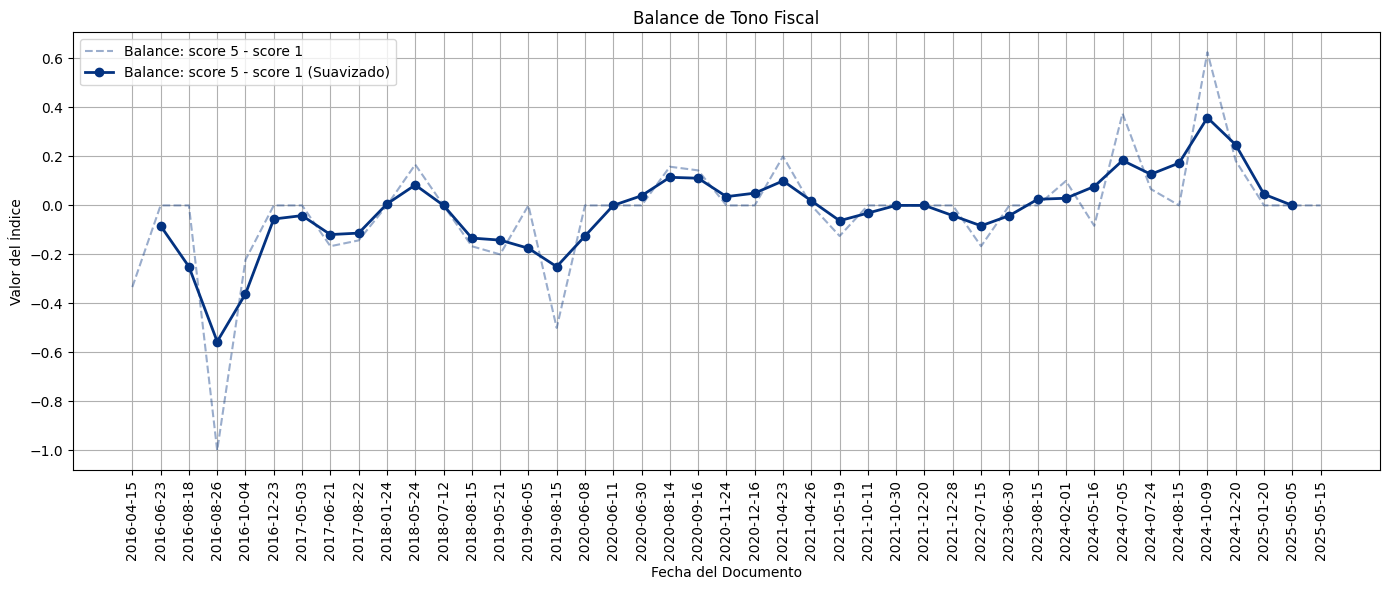

In [97]:
import matplotlib.pyplot as plt
import numpy as np

# Calcular balances
df_doc_summary["balance_A"] = df_doc_summary["score_5"] - df_doc_summary["score_1"]
df_doc_summary["balance_B"] = (
    df_doc_summary["score_5"] + df_doc_summary["score_4"]
    - df_doc_summary["score_1"] - df_doc_summary["score_2"]
)

# Suavizar balances e índice
weights = np.array([1, 2, 1])
for col in ["balance_A", "balance_B", "avg_risk_index"]:
    df_doc_summary[f"{col}_cma"] = (
        df_doc_summary[col]
        .rolling(window=3, center=True)
        .apply(lambda x: np.dot(x, weights)/4, raw=True)
    )

# Gráfico combinado
plt.figure(figsize=(14, 6))

# --- Series originales ---
plt.plot(df_doc_summary["date_str"], df_doc_summary["balance_A"],
         label="Balance: score 5 - score 1", linestyle='--', alpha=0.4, color='#033280')

# --- Series suavizadas ---
plt.plot(df_doc_summary["date_str"], df_doc_summary["balance_A_cma"],
         label="Balance: score 5 - score 1 (Suavizado)", linewidth=2, marker='o', color='#033280')

# Estética
plt.title("Balance de Tono Fiscal")
plt.xlabel("Fecha del Documento")
plt.ylabel("Valor del Índice")
plt.xticks(rotation=90)
plt.grid(True)
plt.legend()
plt.tight_layout()

# Guardar gráfico
plt.savefig("stat_balance.png", dpi=300)
plt.show()



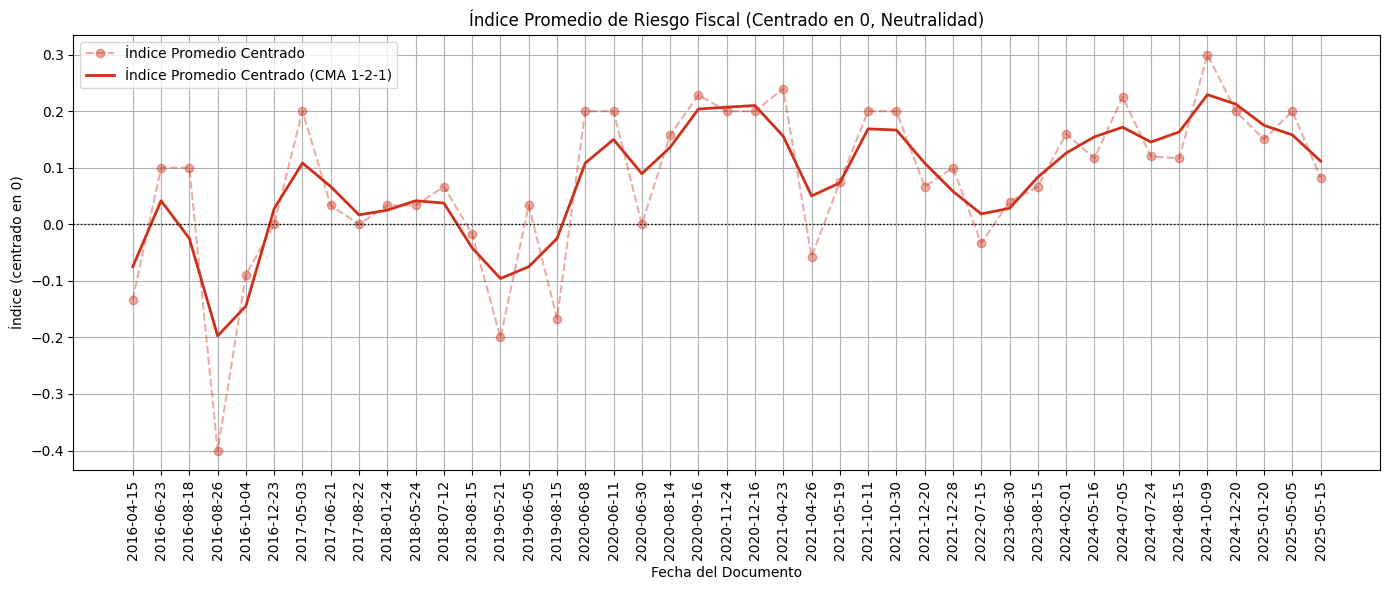

In [96]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Calcular el índice promedio centrado
df_doc_summary["avg_risk_index_centered"] = df_doc_summary["avg_risk_index"] - 0.6

# 2. Aplicar suavizamiento CMA (1-2-1) con extremos refinados
weights = np.array([1, 2, 1])
series = df_doc_summary["avg_risk_index_centered"].copy()

# CMA centrado
cma = series.rolling(window=3, center=True).apply(lambda x: np.dot(x, weights)/4, raw=True)

# Bordes corregidos
first = series.iloc[0]
second = series.iloc[1]
cma.iloc[0] = (3 * first + second) / 4

last = series.iloc[-1]
penultimate = series.iloc[-2]
cma.iloc[-1] = (3 * last + penultimate) / 4

# Guardar resultado
df_doc_summary["avg_risk_index_centered_cma"] = cma

# 3. Graficar y guardar como PNG
plt.figure(figsize=(14, 6))

# Serie original (transparente)
plt.plot(df_doc_summary["date_str"], df_doc_summary["avg_risk_index_centered"],
         label="Índice Promedio Centrado", linestyle='--',
         marker='o', alpha=0.4, color="#cd301b")

# Serie suavizada
plt.plot(df_doc_summary["date_str"], df_doc_summary["avg_risk_index_centered_cma"],
         label="Índice Promedio Centrado (CMA 1-2-1)", linewidth=2, color="#cd301b")

# Eje horizontal en cero
plt.axhline(0, color='black', linestyle=':', linewidth=1)

# Estética
plt.title("Índice Promedio de Tono Fiscal (Centrado en 0, Neutralidad)")
plt.xlabel("Fecha del Documento")
plt.ylabel("Índice (centrado en 0)")
plt.xticks(rotation=90)
plt.grid(True)
plt.legend()
plt.tight_layout()

# Guardar como PNG
plt.savefig("fiscal_tone_index.png", dpi=300)
#plt.close()
plt.show()
